In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from signals import *
from frequencyestimator import *
import time
import copy

sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})

<Figure size 640x480 with 0 Axes>

# Example Implementation

Here we provide a minimal working example demonstrating how to use the code to estimate the amplitude using the ESPIRIT algorithm.

In [46]:
# For reproducibility
# np.random.seed(7)
# Set the per oracle noise parameter (See Eq. 18)
eta=0
# Set the array parameters (See Thm. II.2 and Eq. 12) 
narray = [2]*10
# Set the actual angle
theta = np.pi/4 #np.arcsin(a)

# This sets up the simulation that simulates the measured amplitudes at the various physical locations.
# It uses a C=1.5 value, which corresponds to the sampling schedule given in Eq. 16. The variable C here 
# is the parameter K in the paper.
ula_signal = TwoqULASignal(M=narray, C=5)
# Number of Monte Carlo trials used to estimate statistics. We tend to use 500 in the paper. Choose 100 here for speed.
num_mc = 10
thetas = np.zeros(num_mc, dtype = float)
errors = np.zeros(num_mc, dtype = float)

# Sets up the ESPIRIT object to estimate the amplitude
espirit = ESPIRIT()

for k in range(num_mc):
    signal = ula_signal.estimate_signal(ula_signal.n_samples, theta, eta=eta)
    # This estimates the covariance matrix of Eq. 8 using the approch given in DOI:10.1109/LSP.2015.2409153
    R = -1*ula_signal.get_cov_matrix_toeplitz(signal)
    '''TODO:
    - 2n+1 vs n (phase shift)
    ''' 
    # This estimates the angle using the ESPIRIT algorithm
    theta_est, angle = espirit.estimate_theta_toeplitz(R)
    # R = ula_signal.get_cov_matrix(signal)
    # theta_est, angle = espirit.estimate_theta(R)
    print(angle)
    # Estimate the error between estimated a and actual a
    error = np.abs(np.sin(theta)-np.sin(theta_est)) 
    thetas[k] = theta_est            
    errors[k] = error

# Compute the total number of queries. The additional count of ula_signal.n_samples[0] is to 
# account for the fact that the Grover oracle has two invocations of the unitary U, but is 
# preceded by a single invocation of U (see Eq. 2 in paper). This accounts for the shots required
# for that single U operator, which costs half as much as the Grover oracle.
num_queries = 2*np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]
# Compute the maximum single query
max_single_query = np.max(ula_signal.depths)

print(f'Array parameters: {narray}')
print(f'Number of queries: {num_queries}')
print(f'theta: {theta}')
print(f'Ave theta estimated: {np.mean(thetas)}')
print(f'a = {np.sin(theta)}; a_est = {np.sin(np.mean(thetas))}')
print(f'Max Single Query: {max_single_query}')
print(f'99% percentile: {np.percentile(errors, 99):e}')
print(f'95% percentile: {np.percentile(errors, 95):e}')
print(f'68% percentile: {np.percentile(errors, 68):e}')
print()


[-3.11716223  2.74902817]
[-2.94564354 -3.13896147]
[ 2.35679673 -3.09228625]
[-3.11168228  3.12313981]
[3.13933038 3.13632792]
[ 2.94543054 -1.57086776]
[3.13807693 3.13552996]
[-3.1284206  -3.09117152]
[-3.11112284  3.12373403]
[-3.12853532 -3.13541076]
Array parameters: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Number of queries: 20415
theta: 0.7853981633974483
Ave theta estimated: 0.8023918363967082
a = 0.7071067811865475; a_est = 0.7190204458223209
Max Single Query: 512
99% percentile: 1.162867e-01
95% percentile: 8.431669e-02
68% percentile: 8.815543e-03



In [54]:
# For reproducibility
# np.random.seed(7)
# Set the per oracle noise parameter (See Eq. 18)
eta=0
# Set the array parameters (See Thm. II.2 and Eq. 12) 
narray = [2]*10
# Set the actual angle
theta = np.pi/4.5

# This sets up the simulation that simulates the measured amplitudes at the various physical locations.
# It uses a C=1.5 value, which corresponds to the sampling schedule given in Eq. 16. The variable C here 
# is the parameter K in the paper.
ula_signal = TwoqULASignal(M=narray, C=3)
# Number of Monte Carlo trials used to estimate statistics. We tend to use 500 in the paper. Choose 100 here for speed.
num_mc = 100
thetas = np.zeros(num_mc, dtype = float)
errors = np.zeros(num_mc, dtype = float)

# Sets up the ESPIRIT object to estimate the amplitude
espirit = ESPIRIT()

for k in range(num_mc):
    signal = ula_signal.estimate_signal(ula_signal.n_samples, theta, eta=eta)
    # This estimates the covariance matrix of Eq. 8 using the approch given in DOI:10.1109/LSP.2015.2409153
    R = -1*ula_signal.get_cov_matrix_toeplitz(signal)
    '''TODO:
    - 2n+1 vs n (phase shift)
    ''' 
    # This estimates the angle using fft
    fft = np.abs(np.fft.fft(R))

    amax = np.argmax(fft[:len(fft)//2])
    angle = [np.pi*(len(fft)-amax)/(2*len(fft)) , np.pi*(amax)/(2*len(fft))]
    # R = ula_signal.get_cov_matrix(signal)
    # theta_est, angle = espirit.estimate_theta(R)
    # print(angle)
    # Estimate the error between estimated a and actual a
    differences = [np.abs(np.sin(theta) - np.sin(angle[0])), np.abs(np.sin(theta) - np.sin(angle[1]))]
    idx = np.argmin(differences)
    error = differences[idx]
    theta_est = angle[idx]
 
    thetas[k] = theta_est            
    errors[k] = error

# Compute the total number of queries. The additional count of ula_signal.n_samples[0] is to 
# account for the fact that the Grover oracle has two invocations of the unitary U, but is 
# preceded by a single invocation of U (see Eq. 2 in paper). This accounts for the shots required
# for that single U operator, which costs half as much as the Grover oracle.
num_queries = np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]//2
# Compute the maximum single query
max_single_query = np.max(ula_signal.depths)

print(f'Array parameters: {narray}')
print(f'Number of queries: {num_queries}')
print(f'theta: {theta}')
print(f'Ave theta estimated: {np.mean(thetas)}')
print(f'a = {np.sin(theta)}; a_est = {np.sin(np.mean(thetas))}')
print(f'Max Single Query: {max_single_query}')
print(f'99% percentile: {np.percentile(errors, 99):e}')
print(f'95% percentile: {np.percentile(errors, 95):e}')
print(f'68% percentile: {np.percentile(errors, 68):e}')
print(f'95% percentile constant factor: {num_queries*np.percentile(errors, 95):e}')
print()


Array parameters: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Number of queries: 6124
theta: 0.6981317007977318
Ave theta estimated: 0.6980714030999582
a = 0.6427876096865393; a_est = 0.6427414178017273
Max Single Query: 512
99% percentile: 5.060593e-04
95% percentile: 6.327715e-05
68% percentile: 6.327715e-05
95% percentile constant factor: 3.875092e-01



0.0015744775438756298 0.0015779911827212834


(array([0.70868126, 0.70552879]), 0.7071067811865475)

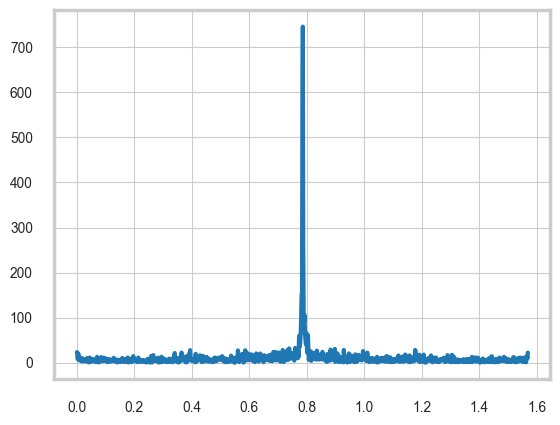

In [51]:
R = R[len(R)//2:]

fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

print(np.abs(np.sin(theta) - np.sin(np.pi*(len(fft)-amax)/(2*len(fft)))), np.abs(np.sin(theta) - np.sin(np.pi*(amax)/(2*len(fft)))))
np.sin( [np.pi*(len(fft)-amax)/(2*len(fft)) , np.pi*(amax)/(2*len(fft))]), np.sin(theta)

In [5]:
np.pi/6, np.pi/5, np.pi/4, np.pi/3, np.pi/2

(0.5235987755982988,
 0.6283185307179586,
 0.7853981633974483,
 1.0471975511965976,
 1.5707963267948966)

In [6]:
eta=0
# Set the array parameters (See Thm. II.2 and Eq. 12) 
narray = [2]*10
# Set the actual angle
N=6
thetas = np.array([((i+1)/(N+1))*np.pi/2 for i in range(N)]) #np.arcsin(a)

# This sets up the simulation that simulates the measured amplitudes at the various physical locations.
# It uses a C=1.5 value, which corresponds to the sampling schedule given in Eq. 16. The variable C here 
# is the parameter K in the paper.
ula_signal = TwoqULASignal(M=narray, C=5)
thetas_est = np.zeros(len(thetas), dtype = float)
# Sets up the ESPIRIT object to estimate the amplitude
espirit = ESPIRIT()

for i,theta in enumerate(thetas):
    signal = ula_signal.estimate_signal(ula_signal.n_samples, theta, eta=eta)
    # This estimates the covariance matrix of Eq. 8 using the approch given in DOI:10.1109/LSP.2015.2409153
    R = ula_signal.get_cov_matrix_toeplitz(signal)
    '''TODO:
    - 2n+1 vs n (phase shift)
    ''' 
    # This estimates the angle using the ESPIRIT algorithm
    theta_est, angle = espirit.estimate_theta_toeplitz(R)
    thetas_est[i] = np.abs(angle[0])
    

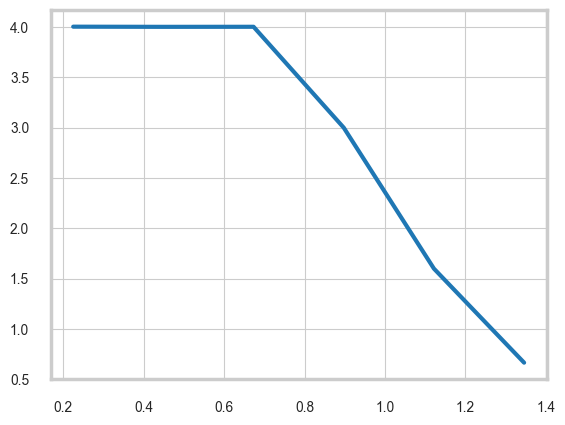

In [7]:
plt.plot(thetas, thetas_est/thetas)

In [8]:
factors = theta_est/thetas
factors

array([6.00020695, 3.00010348, 2.00006898, 1.50005174, 1.20004139,
       1.00003449])

In [9]:
factors_shifted = np.ones(len(factors))
factors_shifted = np.roll(factors, -1)
factors_shifted[-1] = 1
factors_shifted


array([3.00010348, 2.00006898, 1.50005174, 1.20004139, 1.00003449,
       1.        ])

In [10]:
factors/factors_shifted

array([2.        , 1.5       , 1.33333333, 1.25      , 1.2       ,
       1.00003449])

In [18]:
np.kron([1,2], [3,4])

array([3, 4, 6, 8])

In [81]:
# Set the array parameters (See Thm. II.2 and Eq. 12) 
q = 6
narray = [2]*(2*q+2)
# Set the actual angle
thetas = np.pi/5

# This sets up the simulation that simulates the measured amplitudes at the various physical locations.
# It uses a C=1.5 value, which corresponds to the sampling schedule given in Eq. 16. The variable C here 
# is the parameter K in the paper.
ula_signal = TwoqULASignal(M=narray, C=2)

# Sets up the ESPIRIT object to estimate the amplitude
espirit = ESPIRIT()

signal = ula_signal.estimate_signal(ula_signal.n_samples, theta)

signal

array([ 3.16227766e-01+0.9486833j , -4.47213595e-01-0.89442719j,
        8.05055837e-01+0.59319904j,  9.86393924e-01+0.16439899j,
        4.54076609e-02-0.99896854j, -3.30350425e-01+0.94385836j,
       -9.13811549e-01+0.40613847j, -6.40184400e-01-0.76822128j,
        7.68221280e-01+0.6401844j ,  9.86393924e-01-0.16439899j,
        2.87347886e-01-0.95782629j, -6.40184400e-01+0.76822128j,
       -9.48683298e-01+0.31622777j,  6.12323400e-17-1.j        ,
        7.07106781e-01+0.70710678j])

In [82]:
ula_signal.virtual_locations[-1]

array([-57344, -57343, -57342, ...,  57342,  57343,  57344])

In [116]:
from math import factorial

def index_I(q, N, l, i):
    s1 = 0
    s2 = 0
    for j in range(l):
        s1 += N**(q - j - 1) * i[j]
    for j in range(q-l):
        s2 += N**(q - l - j - 1) * i[q + j]
    
    return s1 + s2

def index_J(q, N, l, i):
    s1 = 0
    s2 = 0
    for j in range(l):
        s1 += N**(q - j - 1) * i[2*q - l + j]
    for j in range(q-l):
        s2 += N**(q - l - j - 1) * i[l + j]
    
    return s1 + s2

def comb_factor(q):
    s = 0
    for p in range(1, 2*q + 1):
        s += (-1)**p * factorial(p-1)
    return s

def cumulant_signal(signal, i):
    res = 1
    for n in range(len(i)):
        if n < len(i)//2:
            res = res * signal[i[n]]
        else:
            res = res * np.conj(signal[i[n]])
    return res
    


In [132]:
q = 4
N = 10
l=q//2

from itertools import product

comb = product(list(range(N)), repeat=2*q)

I_indices = []
J_indices = []

R = np.zeros((N**q, N**q), dtype=complex)

for i in comb:
    # print(i)
    I_index = index_I(q, N, l, i)
    J_index = index_J(q, N, l, i)
    I_indices.append(I_index)
    J_indices.append(J_index)

    # R[I_index][J_index] = cumulant_signal(signal=signal, i=i) #+ R[I_index][J_index]


KeyboardInterrupt: 

In [127]:
N**(8)

100000000

In [114]:
len(set(I_indices))*len(set(J_indices))

10000

In [119]:
len(R)

100

In [124]:
cvec = R.flatten(order='F')
cvec

array([ 1.        +5.55111512e-17j, -0.98994949-1.41421356e-01j,
        0.81733903+5.76157020e-01j, ..., -0.5051792 +8.63014469e-01j,
        0.65252314-7.57768802e-01j,  1.        +0.00000000e+00j])

In [128]:
2**N

1024

In [130]:
len(I_indices), len(set(I_indices))

(10000, 100)

In [131]:
I_indices

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
